In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# used to supress display of warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report

import os

import cv2

from tensorflow.keras.models import load_model

import random, copy, math, time

C:\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from utils import *

In [3]:
with open("model_utils.pkl","rb") as f:
    metadata, embeddings, pipeline, le = pickle.load(f)

In [4]:
x = embeddings

In [5]:
y = np.array([m.name[5:].title() for m in metadata])

In [6]:
f.close()

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, stratify = y)

In [9]:
import pandas as pd

In [10]:
pd.Series(y_train).value_counts()

Leonardo Dicaprio     189
Robert Downey Jr      185
Katherine Langford    182
Alexandra Daddario    179
Elizabeth Olsen       176
                     ... 
Jeff Bezos             84
Morgan Freeman         83
Cristiano Ronaldo      78
Mark Zuckerberg        75
Lionel Messi           68
Length: 105, dtype: int64

In [11]:
y_train

array(['Chris Pratt', 'Tuppence Middleton', 'Camila Mendes', ...,
       'Natalie Dormer', 'Eliza Taylor', 'Emilia Clarke'], dtype='<U22')

In [12]:
from collections import Counter
from matplotlib.patches import Patch

# Compute the distribution of examples across classes
def plot_class_distribution(y,title,filename,x_label='Celebrities',y_label='Number of Samples'):
    class_distribution = Counter(y)

    # Extract class names and corresponding counts
    class_names = list(class_distribution.keys())
    class_counts = list(class_distribution.values())

    # Define custom frequency ranges and colors
    frequency_ranges = [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250)]  # Define frequency ranges
    colors = ['yellow','green', 'blue', 'orange', 'red']  # Define colors for each range

    # Create a dictionary to map each class to its corresponding color
    class_color_map = {}
    for cls, count in zip(class_names, class_counts):
        for i, (start, end) in enumerate(frequency_ranges):
            if start <= count and count < end:
                class_color_map[cls] = colors[i]
                break

    # Plotting
    plt.figure(figsize=(20, 10))  # Increase the figure width
    bars = plt.bar(class_names, class_counts)

    # Set colors for each bar based on class
    for bar, cls in zip(bars, class_names):
        bar.set_color(class_color_map.get(cls, 'gray'))  # Assign color based on the class

    # Create custom legend
    legend_elements = []
    for (start, end), color in zip(frequency_ranges, colors):
        label = f'{start}-{end}'
        legend_elements.append(Patch(color=color, label=label))

    plt.legend(handles=legend_elements, title='Frequency Ranges')

    plt.xlabel('Celebrities')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=90, ha='right')  # Rotate the x-axis labels for better visibility
    plt.grid(axis='y', which='major')  # Show only horizontal grid lines
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.savefig(filename)
    plt.show()

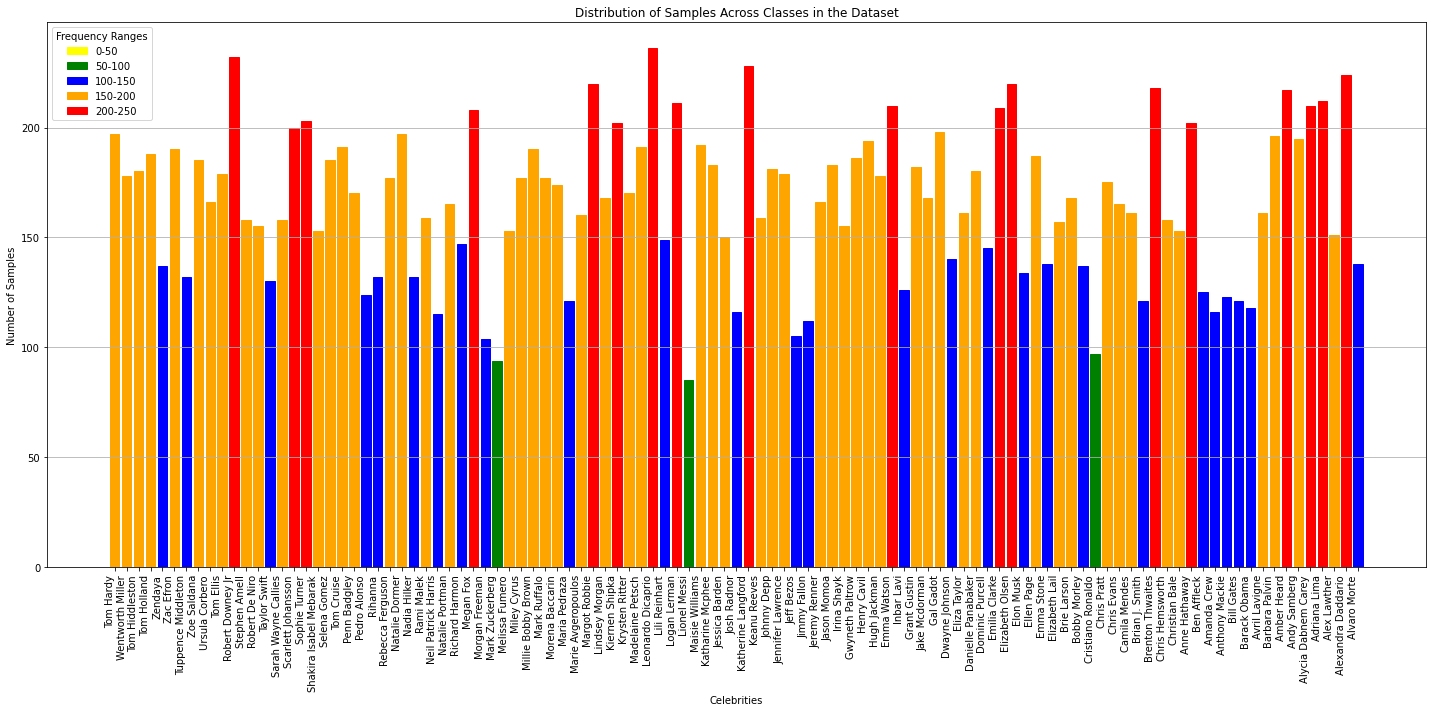

In [13]:
plot_class_distribution(y,'Distribution of Samples Across Classes in the Dataset','y_dist.jpg')

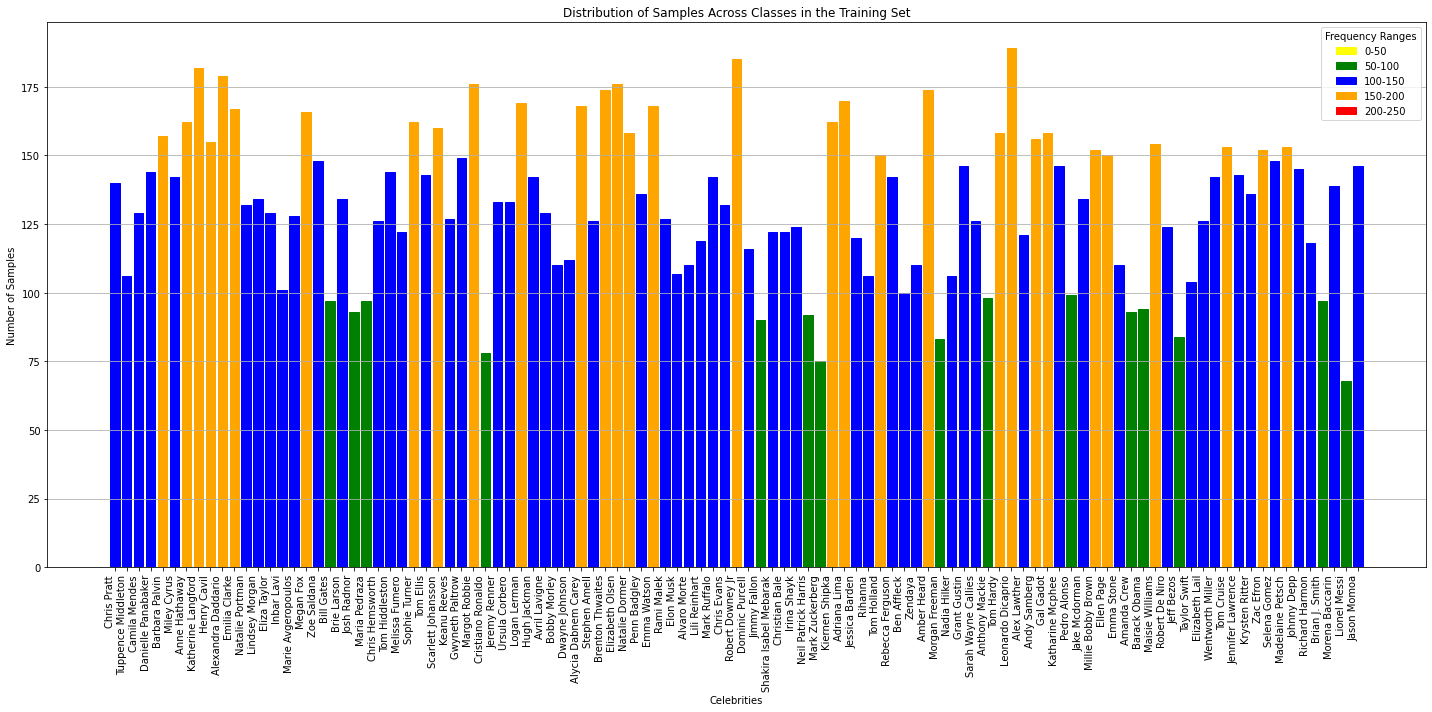

In [14]:
plot_class_distribution(y_train,'Distribution of Samples Across Classes in the Training Set','y_train_dist.jpg')

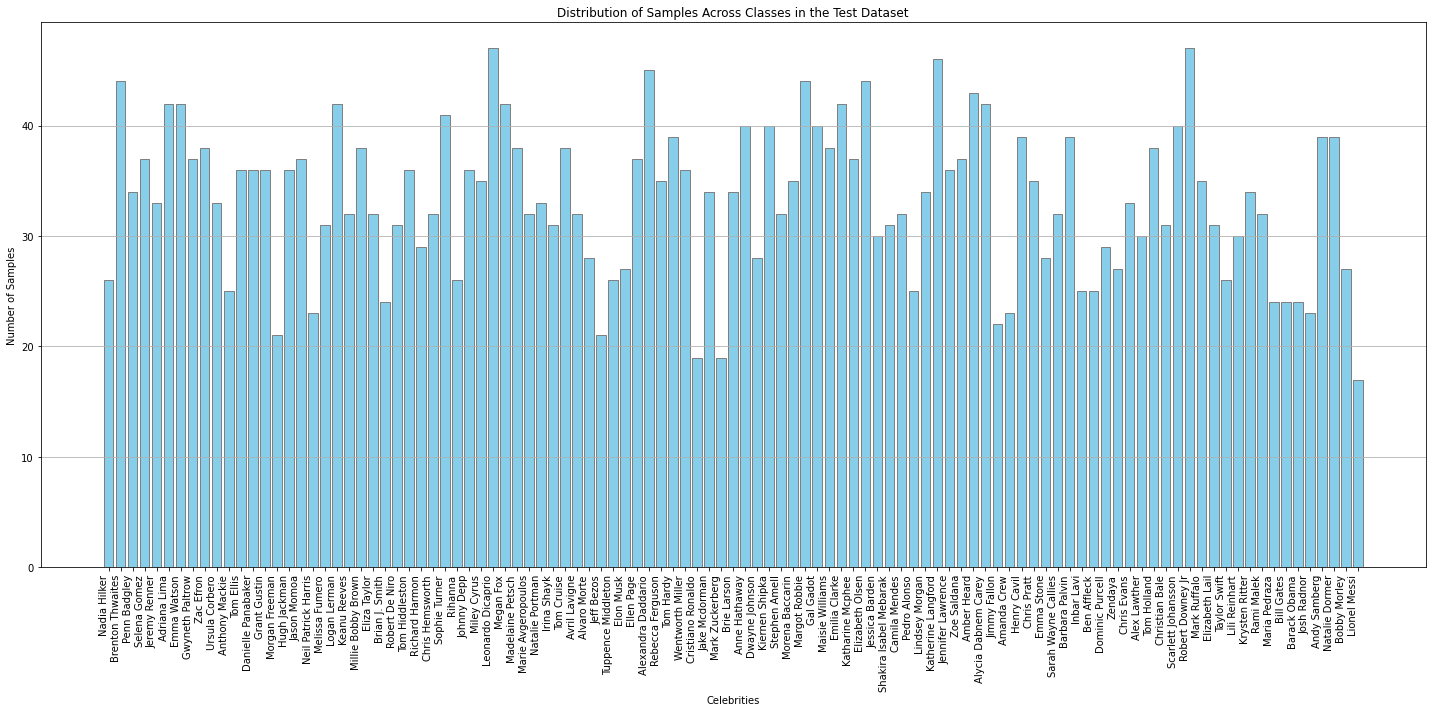

In [15]:
# Compute the distribution of examples across classes
class_distribution = Counter(y_test)

# Extract class names and corresponding counts
class_names = list(class_distribution.keys())
class_counts = list(class_distribution.values())

# Define custom frequency ranges and colors
frequency_ranges = [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250)]  # Define frequency ranges
colors = ['skyblue','green', 'blue', 'orange', 'red']  # Define colors for each range

# Create a dictionary to map each class to its corresponding color
class_color_map = {}
for cls, count in zip(class_names, class_counts):
    for i, (start, end) in enumerate(frequency_ranges):
        if start <= count and count < end:
            class_color_map[cls] = colors[i]
            break

# Plotting
plt.figure(figsize=(20, 10))  # Increase the figure width
bars = plt.bar(class_names, class_counts)

# Set colors for each bar based on class
for bar, cls in zip(bars, class_names):
    bar.set_color(class_color_map.get(cls, 'gray'))  # Assign color based on the class
    bar.set_edgecolor('gray')

# Create custom legend
legend_elements = []
for (start, end), color in zip(frequency_ranges, colors):
    label = f'{start}-{end}'
    legend_elements.append(Patch(color=color, label=label))

# plt.legend(handles=legend_elements, title='Frequency Ranges')

plt.xlabel('Celebrities')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples Across Classes in the Test Dataset')
plt.xticks(rotation=90, ha='right')  # Rotate the x-axis labels for better visibility
plt.grid(axis='y', which='major')  # Show only horizontal grid lines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('y_test_dist.jpg')
plt.show()

In [16]:
len(np.unique(y_train))

105

In [17]:
len(np.unique(y_test))

105

In [18]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)

In [19]:
x_test_std = scaler.transform(x_test)

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

In [21]:
le2 = LabelEncoder()
y_train_encoded = le2.fit_transform(y_train)

In [22]:
print(le2.classes_)
y_test_encoded = le2.transform(y_test)

['Adriana Lima' 'Alex Lawther' 'Alexandra Daddario' 'Alvaro Morte'
 'Alycia Dabnem Carey' 'Amanda Crew' 'Amber Heard' 'Andy Samberg'
 'Anne Hathaway' 'Anthony Mackie' 'Avril Lavigne' 'Barack Obama'
 'Barbara Palvin' 'Ben Affleck' 'Bill Gates' 'Bobby Morley'
 'Brenton Thwaites' 'Brian J. Smith' 'Brie Larson' 'Camila Mendes'
 'Chris Evans' 'Chris Hemsworth' 'Chris Pratt' 'Christian Bale'
 'Cristiano Ronaldo' 'Danielle Panabaker' 'Dominic Purcell'
 'Dwayne Johnson' 'Eliza Taylor' 'Elizabeth Lail' 'Elizabeth Olsen'
 'Ellen Page' 'Elon Musk' 'Emilia Clarke' 'Emma Stone' 'Emma Watson'
 'Gal Gadot' 'Grant Gustin' 'Gwyneth Paltrow' 'Henry Cavil' 'Hugh Jackman'
 'Inbar Lavi' 'Irina Shayk' 'Jake Mcdorman' 'Jason Momoa' 'Jeff Bezos'
 'Jennifer Lawrence' 'Jeremy Renner' 'Jessica Barden' 'Jimmy Fallon'
 'Johnny Depp' 'Josh Radnor' 'Katharine Mcphee' 'Katherine Langford'
 'Keanu Reeves' 'Kiernen Shipka' 'Krysten Ritter' 'Leonardo Dicaprio'
 'Lili Reinhart' 'Lindsey Morgan' 'Lionel Messi' 'Logan Lerm

In [23]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [22 99 19 ... 76 28 33]
y_test_encoded :  [75 16 80 ... 46 92 53]


In [24]:
x_train_pca.shape, y_train_encoded.shape

((13991, 128), (13991,))

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assuming you have your data stored in variables X_train_pca, y_train_encoded
# X_train_pca.shape should be (number_of_samples, 128)
# y_train_encoded.shape should be (number_of_samples,)

# Define the neural network architecture
model = Sequential([
    Dense(512, activation='relu', input_shape=(128,)),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(105, activation='softmax')  # Softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(x_train_pca, y_train_encoded, epochs=100, batch_size=32, validation_split=0.2)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)               

Epoch 42/100
350/350 [==============================] - 2s 7ms/step - loss: 0.3952 - accuracy: 0.9011 - val_loss: 0.1668 - val_accuracy: 0.9596
Epoch 43/100
350/350 [==============================] - 2s 7ms/step - loss: 0.3895 - accuracy: 0.9025 - val_loss: 0.1772 - val_accuracy: 0.9593
Epoch 44/100
350/350 [==============================] - 2s 6ms/step - loss: 0.3613 - accuracy: 0.9054 - val_loss: 0.1766 - val_accuracy: 0.9618
Epoch 45/100
350/350 [==============================] - 2s 7ms/step - loss: 0.3578 - accuracy: 0.9054 - val_loss: 0.1796 - val_accuracy: 0.9578
Epoch 46/100
350/350 [==============================] - 2s 7ms/step - loss: 0.3938 - accuracy: 0.9019 - val_loss: 0.1663 - val_accuracy: 0.9636
Epoch 47/100
350/350 [==============================] - 2s 7ms/step - loss: 0.3797 - accuracy: 0.9023 - val_loss: 0.1665 - val_accuracy: 0.9600
Epoch 48/100
350/350 [==============================] - 2s 7ms/step - loss: 0.3707 - accuracy: 0.9031 - val_loss: 0.1567 - val_accuracy:

Epoch 99/100
350/350 [==============================] - 2s 6ms/step - loss: 0.3161 - accuracy: 0.9249 - val_loss: 0.1863 - val_accuracy: 0.9653
Epoch 100/100
350/350 [==============================] - 2s 6ms/step - loss: 0.3083 - accuracy: 0.9241 - val_loss: 0.1900 - val_accuracy: 0.9625


In [26]:
predictions = model.predict(x_test_pca)

110/110 [==============================] - 0s 2ms/step


In [27]:
predicted_classes = np.argmax(predictions, axis=1)

In [28]:
accuracy_score(y_test_encoded,predicted_classes)

0.9662664379645511

In [29]:
# precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score

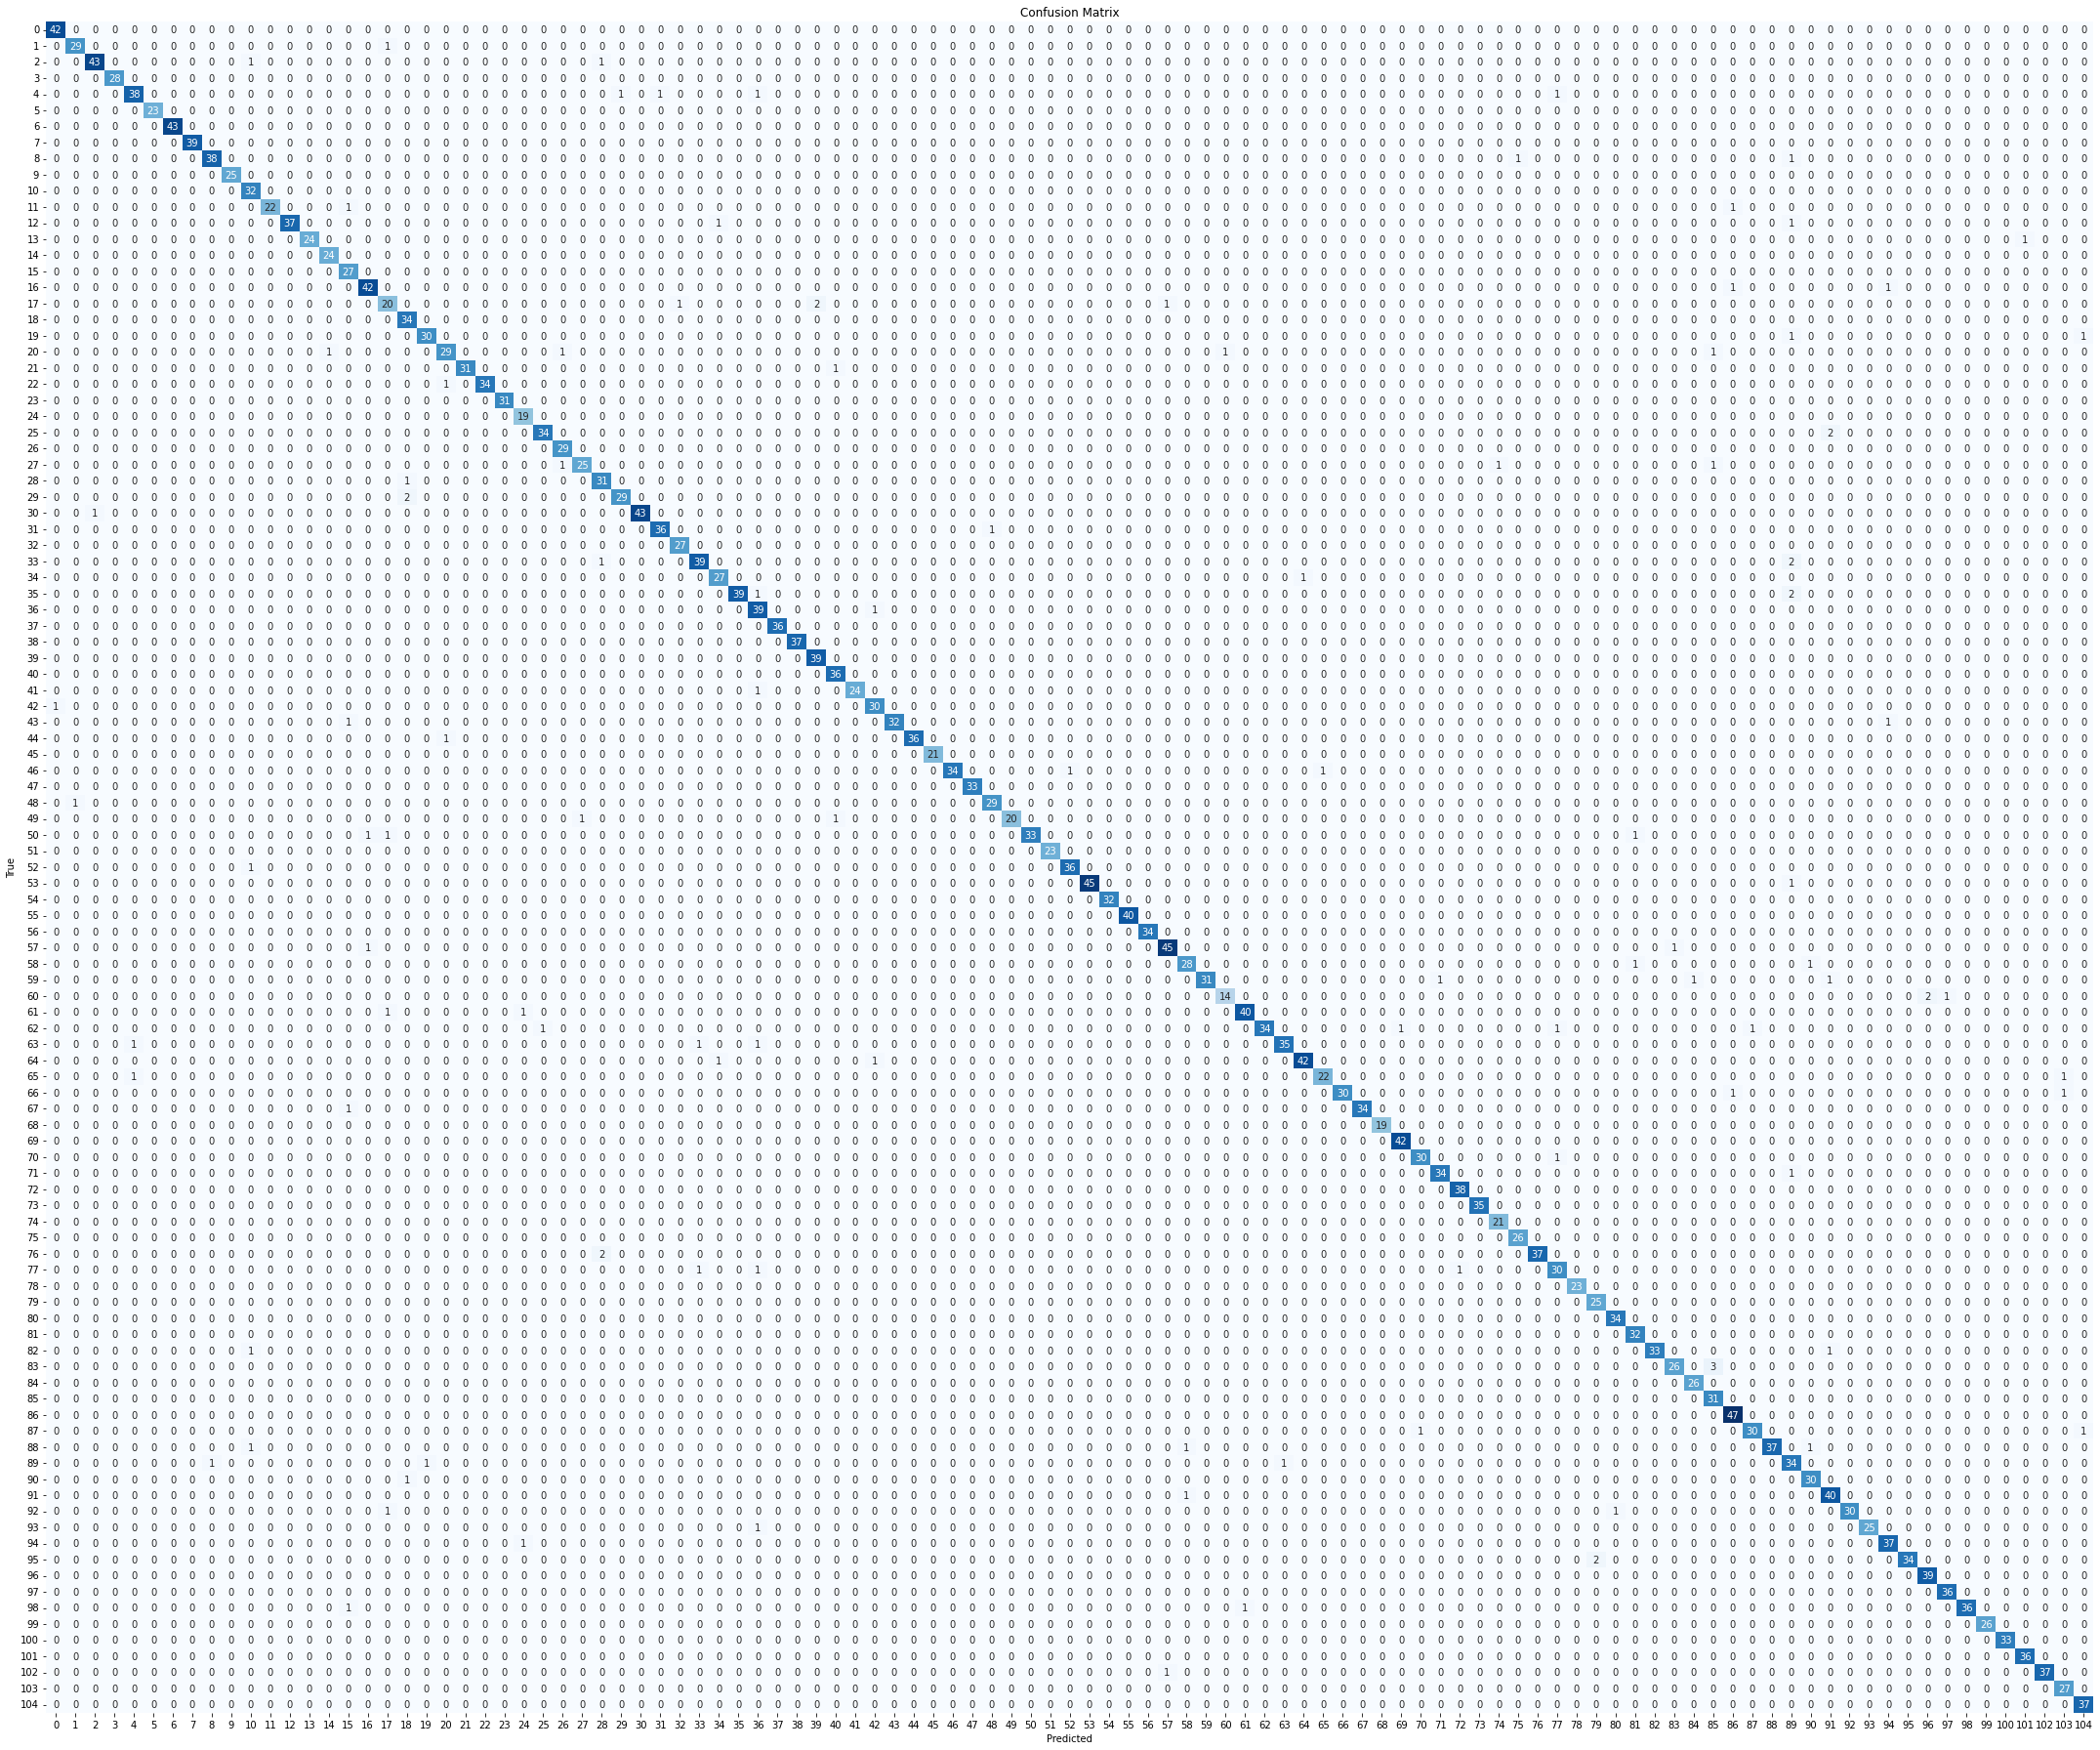

In [30]:
cm = confusion_matrix(y_test_encoded,predicted_classes)
plt.figure(figsize=(30, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.jpg')
plt.show()

In [31]:
# Create a DataFrame from the confusion matrix
classes = le2.classes_

confusion_df = pd.DataFrame(cm,index=classes, columns=classes)

# Calculate total misclassifications for each class
confusion_df['Total_Misclassifications'] = confusion_df.sum(axis=1) - np.diag(confusion_df)

# Sort by total misclassifications and select the top-N confused classes
top_n_confused_classes = confusion_df.sort_values(by='Total_Misclassifications', ascending=False).head(10)

# Visualize the top-N confused classes
print("Top-10 Confused Classes:")
top_n_confused_classes

Top-10 Confused Classes:


Adriana Lima  Alex Lawther  Alexandra Daddario  \
Chris Evans                     0             0                   0   
Alycia Dabnem Carey             0             0                   0   
Madelaine Petsch                0             0                   0   
Brian J. Smith                  0             0                   0   
Lionel Messi                    0             0                   0   
Emilia Clarke                   0             0                   0   
Maisie Williams                 0             0                   0   
Lindsey Morgan                  0             0                   0   
Richard Harmon                  0             0                   0   
Johnny Depp                     0             0                   0   

                     Alvaro Morte  Alycia Dabnem Carey  Amanda Crew  \
Chris Evans                     0                    0            0   
Alycia Dabnem Carey             0                   38            0   
Madelaine Petsch                0                    0            0   
Brian J. Smith                  0                    0            0   
Lionel Messi                    0                    0            0   
Emilia Clarke                   0                    0            0   
Maisie Williams                 0                    1            0   
Lindsey Morgan                  0                    0            0   
Richard Harmon                  0                    0            0   
Johnny Depp                     0                    0            0   

                     Amber Heard  Andy Samberg  Anne Hathaway  Anthony Mackie  \
Chris Evans                    0             0              0               0   
Alycia Dabnem Carey            0             0              0               0   
Madelaine Petsch               0             0              0               0   
Brian J. Smith                 0             0              0               0   
Lionel Messi                   0             0              0               0   
Emilia Clarke                  0             0              0               0   
Maisie Williams                0             0              0               0   
Lindsey Morgan                 0             0              0               0   
Richard Harmon                 0             0              0               0   
Johnny Depp                    0             0              0               0   

                     ...  Tom Hardy  Tom Hiddleston  Tom Holland  \
Chris Evans          ...          0               0            0   
Alycia Dabnem Carey  ...          0               0            0   
Madelaine Petsch     ...          0               0            0   
Brian J. Smith       ...          0               0            0   
Lionel Messi         ...          2               1            0   
Emilia Clarke        ...          0               0            0   
Maisie Williams      ...          0               0            0   
Lindsey Morgan       ...          0               0            0   
Richard Harmon       ...          0               0            0   
Johnny Depp          ...          0               0            0   

                     Tuppence Middleton  Ursula Corbero  Wentworth Miller  \
Chris Evans                           0               0                 0   
Alycia Dabnem Carey                   0               0                 0   
Madelaine Petsch                      0               0                 0   
Brian J. Smith                        0               0                 0   
Lionel Messi                          0               0                 0   
Emilia Clarke                         0               0                 0   
Maisie Williams                       0               0                 0   
Lindsey Morgan                        0               0                 0   
Richard Harmon                        0               0                 0   
Johnny Depp                           0       

In [32]:
confusion_df['Total_Misclassifications'].value_counts()

0    44
1    23
2    23
3    11
4     4
Name: Total_Misclassifications, dtype: int64

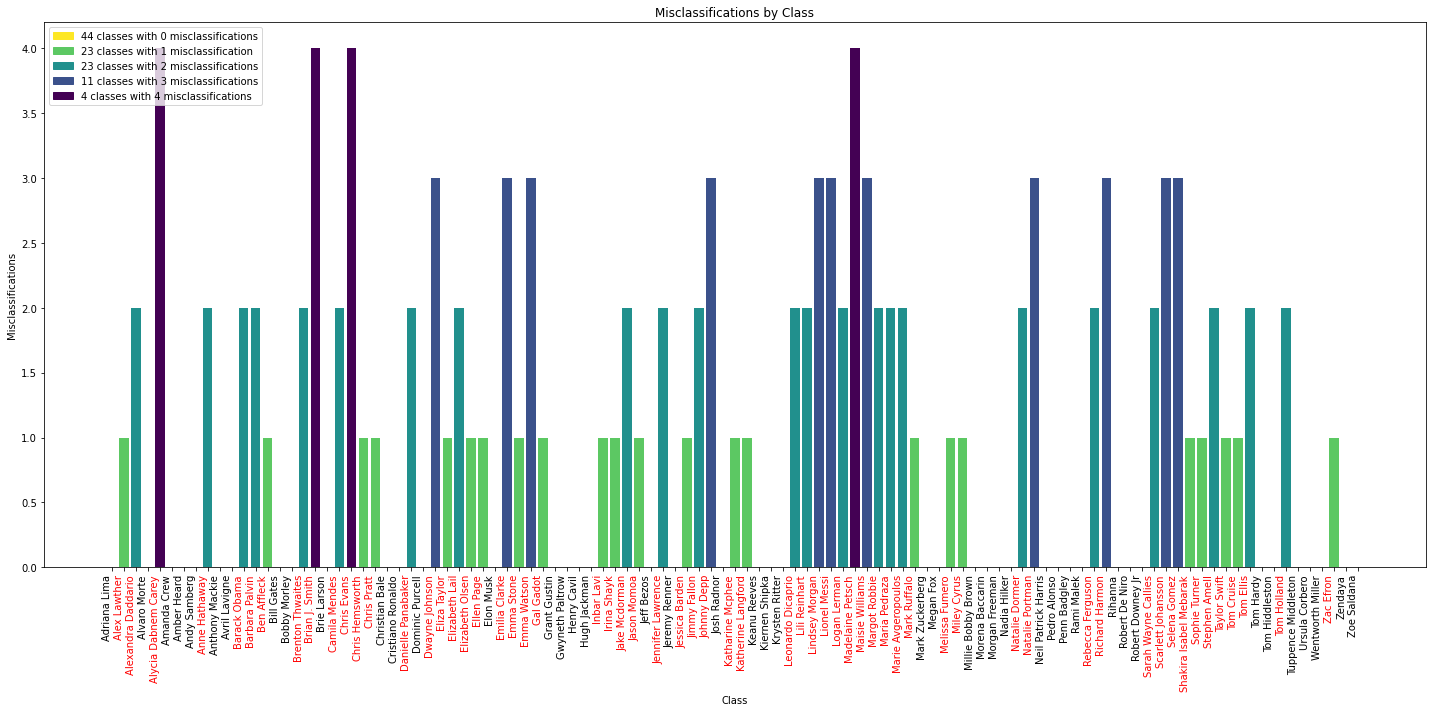

In [33]:
cmap_reversed = plt.cm.viridis.reversed()
# Plot bar graph
plt.figure(figsize=(20, 10))
bars = plt.bar(confusion_df.index, confusion_df['Total_Misclassifications'], color=cmap_reversed(confusion_df['Total_Misclassifications']/max(confusion_df['Total_Misclassifications'])))

# Color labels for classes with non-zero misclassifications
for class_name, misclassification_count in zip(confusion_df.index, confusion_df['Total_Misclassifications']):
    if misclassification_count != 0:
        plt.gca().get_xticklabels()[confusion_df.index.get_loc(class_name)].set_color('red')

plt.xlabel('Class')
plt.ylabel('Misclassifications')
plt.title('Misclassifications by Class')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better visibility

# Create custom legend for colors
legend_handles = []
legend_labels = []
for count, num_classes in confusion_df['Total_Misclassifications'].value_counts().items():
    legend_handles.append(plt.Rectangle((0, 0), 1, 1, color=cmap_reversed(count/max(confusion_df['Total_Misclassifications']))))
    if num_classes==1 and count==1:
        legend_labels.append(f"{num_classes} class with {count} misclassification")
    elif num_classes==1 and count!=1:
        legend_labels.append(f"{num_classes} class with {count} misclassifications")
    elif num_classes!=1 and count==1:
        legend_labels.append(f"{num_classes} classes with {count} misclassification")
    else:
        legend_labels.append(f"{num_classes} classes with {count} misclassifications")
plt.legend(legend_handles, legend_labels, loc='upper left')

plt.tight_layout()
plt.savefig('misclassifications.jpg')
plt.show()


In [34]:
report = classification_report(y_test_encoded,predicted_classes)
print(report,'\n')
report = classification_report(y_test_encoded,predicted_classes, output_dict=True)

# Print aggregate metrics
print("Classification Report:")
#print(report)
print("Precision:", report['macro avg']['precision'])
print("Recall:", report['macro avg']['recall'])
print("F1-score:", report['macro avg']['f1-score'])

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        42
           1       0.97      0.97      0.97        30
           2       0.98      0.96      0.97        45
           3       1.00      1.00      1.00        28
           4       0.95      0.90      0.93        42
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        43
           7       1.00      1.00      1.00        39
           8       0.97      0.95      0.96        40
           9       1.00      1.00      1.00        25
          10       0.89      1.00      0.94        32
          11       1.00      0.92      0.96        24
          12       1.00      0.95      0.97        39
          13       1.00      0.96      0.98        25
          14       0.96      1.00      0.98        24
          15       0.87      1.00      0.93        27
          16       0.95      0.95      0.95        44
          17       0.83    

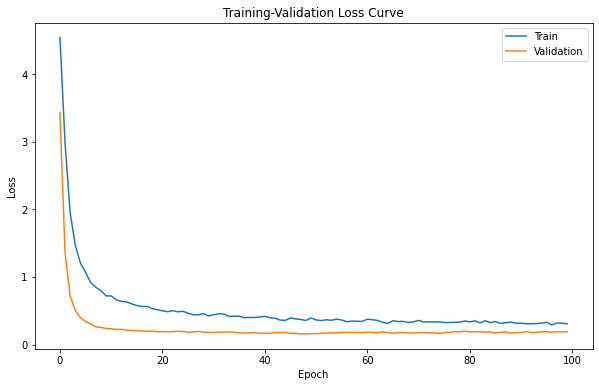

In [35]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training-Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training-Validation Loss Curve.jpg')

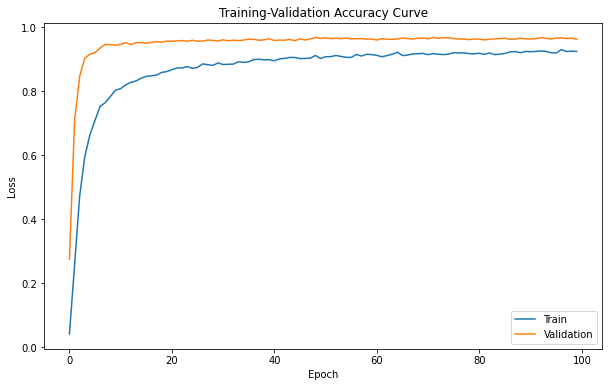

In [36]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training-Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training-Validation Accuracy Curve.jpg')

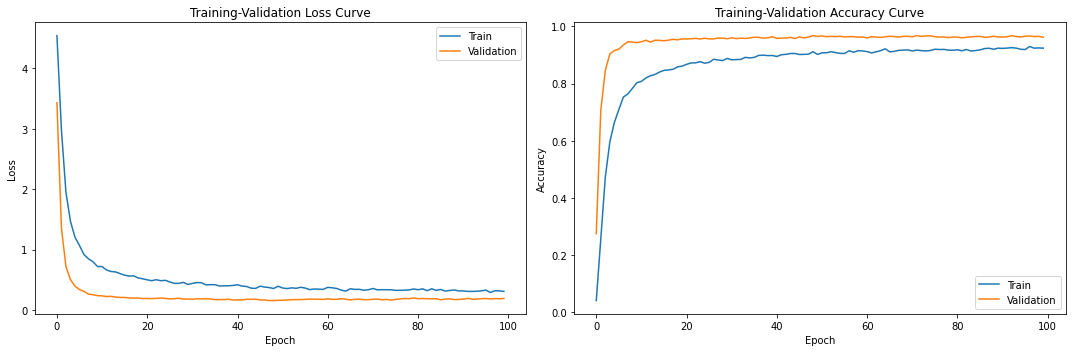

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation loss values
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_title('Training-Validation Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training & validation accuracy values
if 'accuracy' in history.history:
    axes[1].plot(history.history['accuracy'], label='Train')
    axes[1].plot(history.history['val_accuracy'], label='Validation')
    axes[1].set_title('Training-Validation Accuracy Curve')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

plt.tight_layout()

plt.show()

In [38]:
# Load pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    return faces

In [39]:
embedder = load_model("vgg_face_embedder.h5")

In [40]:
embedder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 226, 226, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 226, 226, 64)      0         
 ing2D)                                                          
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                             

In [41]:
import visualkeras

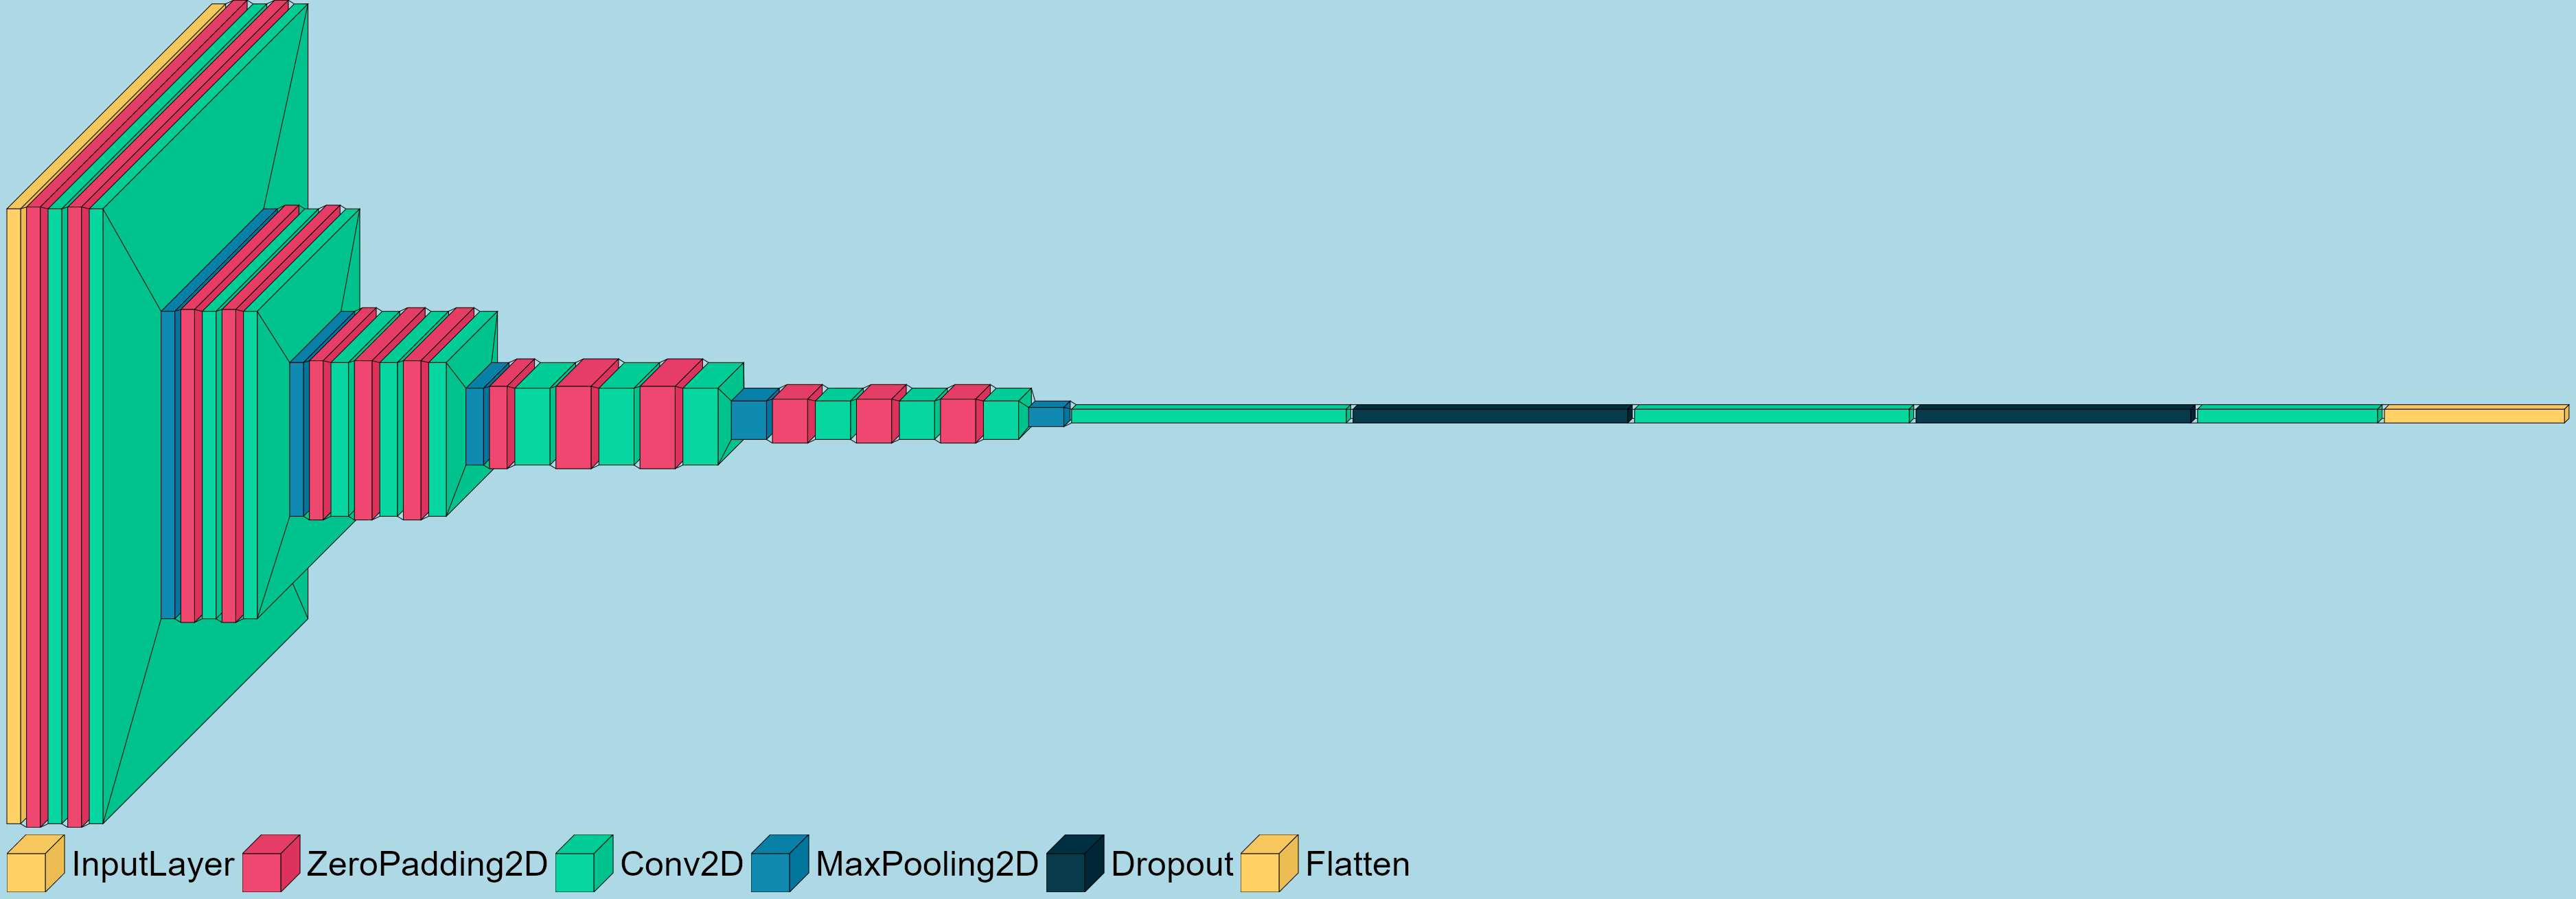

In [42]:
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 50)
visualkeras.layered_view(embedder, legend=True, font=font,background_fill='lightblue', to_file='embedder.png')

In [43]:
def identify(img_name):
    start = time.time()
    try:
        inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{img_name}.jpg")
        gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
        inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        ct = 0
        new_img = copy.deepcopy(inp_img)
        print("Maximum Probabilities:")
        for (x, y, w, h) in inp_faces:
            input_face_region = inp_img[y:y+h, x:x+w]
            img = (input_face_region / 255.).astype(np.float32)
            img = cv2.resize(img, dsize = (224,224))
            embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
            embv_scaled = scaler.transform([embedding_vector])
            embv_pca = pca.transform(embv_scaled)
            #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
            probabs = model.predict(embv_pca)
            if np.max(probabs) > 0.90:
                name = le2.inverse_transform([np.argmax(probabs)])[0]
            else:
                name = 'not recognized'
            print(np.max(probabs),"-", name)
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
            new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
        new_img = new_img[...,::-1]
        plt.figure(figsize=(15,15))
        plt.imshow(new_img)
        end = time.time()
        print("\nTotal Execution Time in Seconds:")
        print(end-start,"s")
    except:
        inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{img_name}.jpeg")
        gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
        inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
        ct = 0
        new_img = copy.deepcopy(inp_img)
        print("Maximum Probabilities:")
        for (x, y, w, h) in inp_faces:
            input_face_region = inp_img[y:y+h, x:x+w]
            img = (input_face_region / 255.).astype(np.float32)
            img = cv2.resize(img, dsize = (224,224))
            embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
            embv_scaled = scaler.transform([embedding_vector])
            embv_pca = pca.transform(embv_scaled)
            #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
            probabs = model.predict(embv_pca)
            if np.max(probabs) > 0.90:
                name = le2.inverse_transform([np.argmax(probabs)])[0]
            else:
                name = 'not recognized'
            print(np.max(probabs),"-", name)
            cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
            new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
        new_img = new_img[...,::-1]
        plt.figure(figsize=(15,15))
        plt.imshow(new_img)
        end = time.time()
        print("\nTotal Execution Time in Seconds:")
        print(end-start,"s")

Maximum Probabilities:
1/1 [==============================] - 0s 64ms/step
0.99877816 - Scarlett Johansson
1/1 [==============================] - 0s 49ms/step
1.0 - Robert Downey Jr
1/1 [==============================] - 0s 47ms/step
1.0 - Mark Ruffalo
1/1 [==============================] - 0s 47ms/step
0.9999877 - Chris Hemsworth
1/1 [==============================] - 0s 31ms/step
0.97575456 - Chris Evans
1/1 [==============================] - 0s 31ms/step
1.0 - Tom Hiddleston
1/1 [==============================] - 0s 31ms/step
1.0 - Jeremy Renner

Total Execution Time in Seconds:
7.549994945526123 s


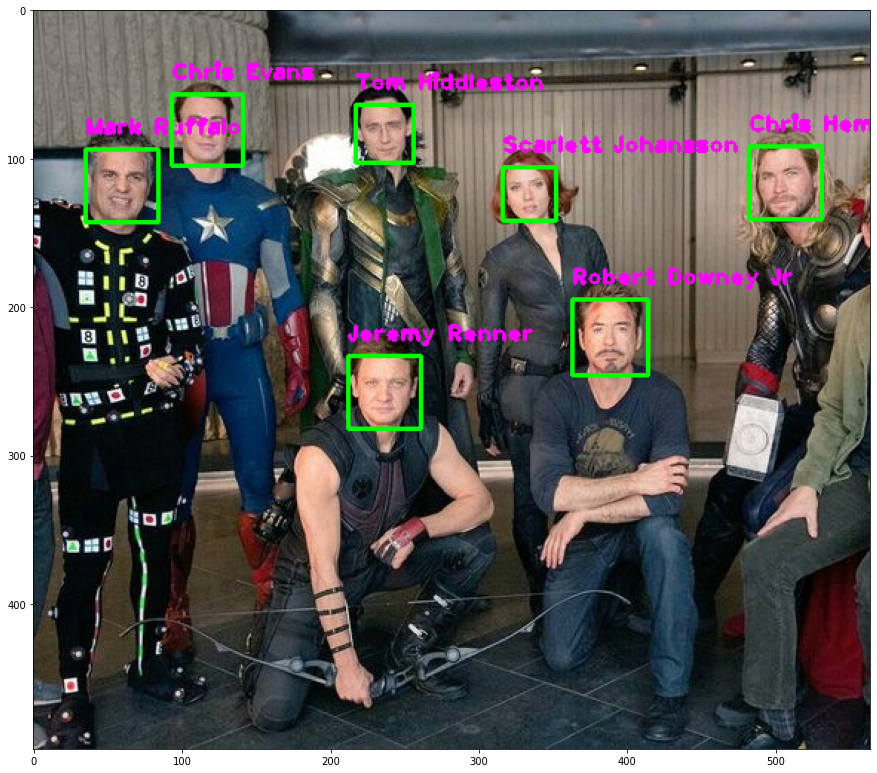

In [44]:
identify('avengers')

Maximum Probabilities:
1/1 [==============================] - 0s 31ms/step
0.9209933 - Chris Evans

Total Execution Time in Seconds:
0.7713901996612549 s


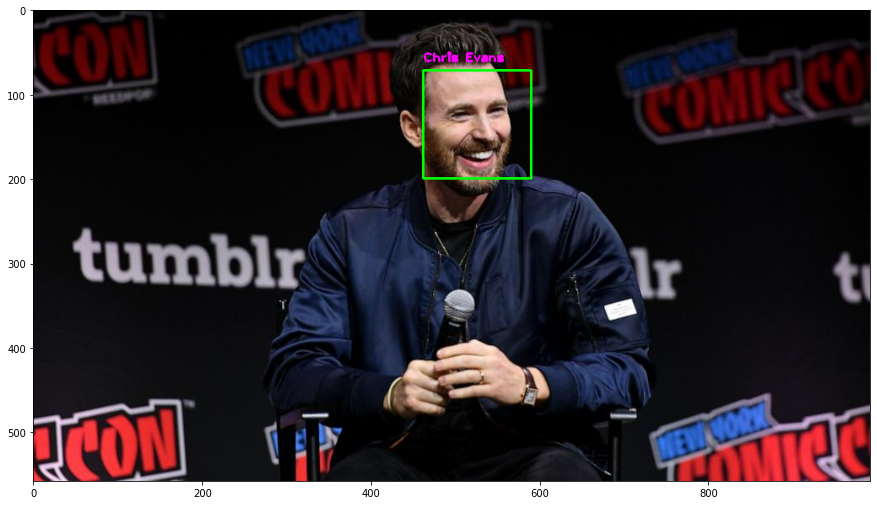

In [45]:
identify('chris_evans')

Maximum Probabilities:
1/1 [==============================] - 0s 42ms/step
0.99546033 - Tom Holland

Total Execution Time in Seconds:
0.7736287117004395 s


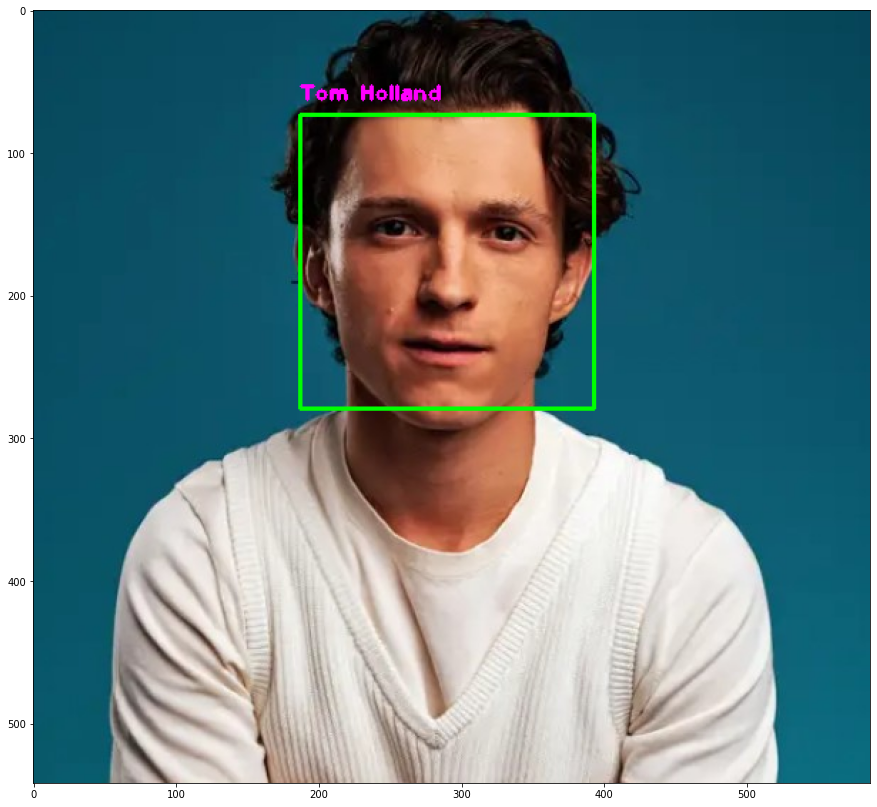

In [46]:
identify('tom_holland')

Maximum Probabilities:
1/1 [==============================] - 0s 16ms/step
0.3708371 - not recognized

Total Execution Time in Seconds:
0.6642603874206543 s


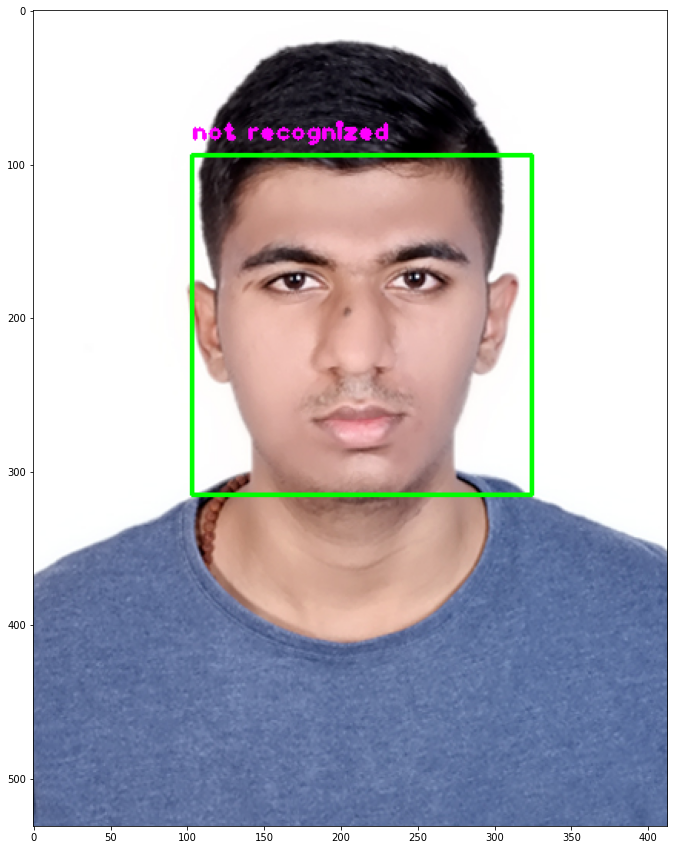

In [48]:
identify('dhruv_limbani')

Maximum Probabilities:
1/1 [==============================] - 0s 16ms/step
0.35981348 - not recognized
1/1 [==============================] - 0s 16ms/step
0.13152078 - not recognized
1/1 [==============================] - 0s 31ms/step
0.35705966 - not recognized
1/1 [==============================] - 0s 47ms/step
0.9999982 - Barack Obama

Total Execution Time in Seconds:
2.9988298416137695 s


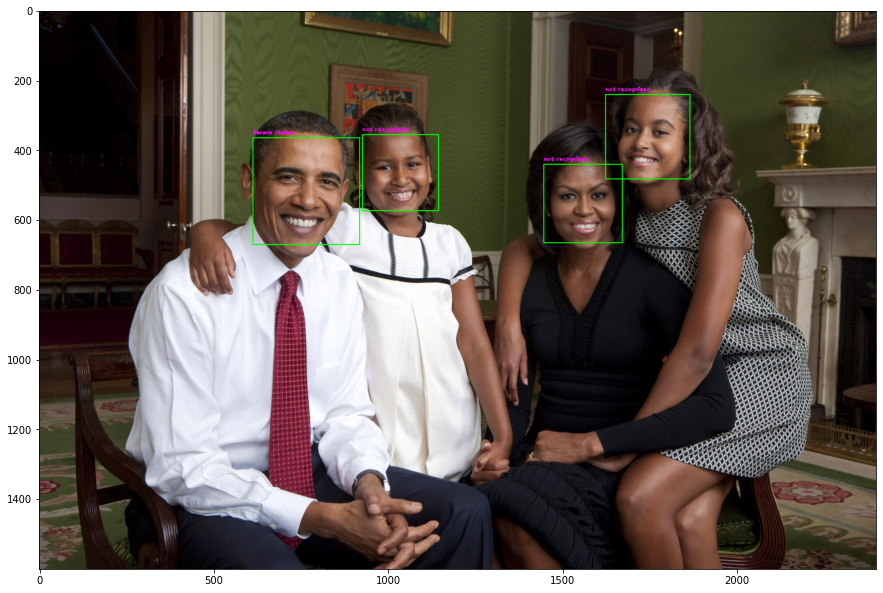

In [49]:
identify('barack_obama_family')

In [50]:
name = "tom_holland"
start = time.time()
try:
    path = rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg"
    print(recognize(path,metadata,embeddings,embedder))
except:
    path = rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg"
    print(recognize(path,metadata,embeddings,embedder))
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start)

pins_Bill Gates

Total Execution Time in Seconds:
2.272345781326294


# Existing Systems:

1) Requires Face images in good lighting conditions for training (mobile face rec unlock) - not ideal for face rec for missing people identification as we need to identify person from whatever images are available

2) Calculates the embeddings of each image in the database (length-2000-4000). To recognize the person, an input image is coverted to same length embedding and that embedding is compared with every other image in the database and a distance is calculated between them. If the distance is lower than threshold, match is found else the person is not recognized.
    
    Advantages:
    - no longer requires images once the embedding is generated. computations can be done on the embeddings itself. privacy is maintained.
    
    
    Disadvantages:
    - takes O(n) time to compare the distances
    - minimum vector leangth of 2000 is required for each image.
    - not suitable for deployment on edge devices as models are 500 mb to 1 gb of size.


# Our Approach

1) Computes the embeddings of each image and further reduces it to 128D vector using PCA
2) Uses SVM algorithm to train on the PCA Vectors
3) Once an image is given as input, it converts it into 128D PCA embedding and then makes probabilistic prediction on the image

    Advantages:
    - no longer requires images once embeddings are generated, privacy is maintained.
    - runs in O(1) time
    - model size is less than 10mb
    - can be deployed easily on edge devices

In [67]:
with open("pcaembdl.pkl","wb") as f:
    pickle.dump([x_train_pca,x_test_pca],f)

In [68]:
f.close()

In [69]:
with open("scaler_pca_ledl","wb") as f:
    pickle.dump([scaler,pca,le2],f)

In [70]:
f.close()

In [71]:
model.save('face_rec_96.h5')

C:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from keras.models import load_model

new_model = load_model('face_rec_96.h5')

C:\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Maximum Probabilities:
1/1 [==============================] - 0s 181ms/step
1.0 - Robert Downey Jr
1/1 [==============================] - 0s 31ms/step
0.9999956 - scarlett johansson
1/1 [==============================] - 0s 18ms/step
1.0 - Mark Ruffalo
1/1 [==============================] - 0s 47ms/step
0.9999056 - Chris Hemsworth
1/1 [==============================] - 0s 16ms/step
1.0 - Jeremy Renner
1/1 [==============================] - 0s 55ms/step
0.99595404 - Chris Evans
1/1 [==============================] - 0s 47ms/step
1.0 - Tom Hiddleston

Total Execution Time in Seconds:
4.955454349517822 s


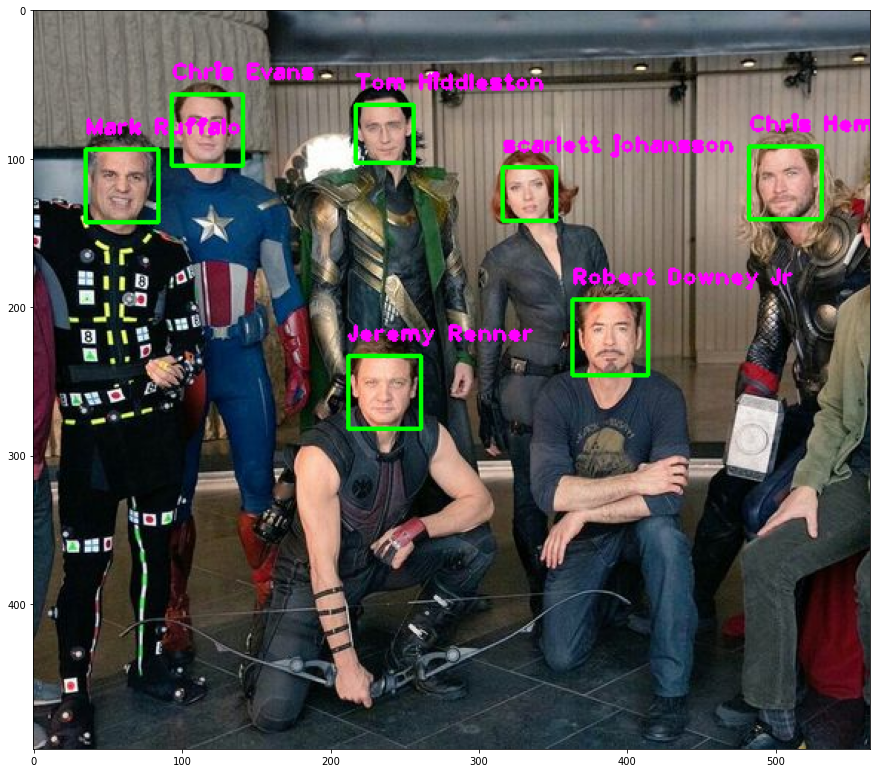

In [73]:
name = 'avengers'
start = time.time()
try:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpg")
except:
    inp_img = cv2.imread(rf"D:\Users\DELL\Desktop\Major Project\Github Face Rec\test_images\{name}.jpeg")
gray=cv2.cvtColor(inp_img, cv2.COLOR_BGR2GRAY)
inp_faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
ct = 0
new_img = copy.deepcopy(inp_img)
print("Maximum Probabilities:")
for (x, y, w, h) in inp_faces:
    input_face_region = inp_img[y:y+h, x:x+w]
    img = (input_face_region / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = embedder.predict(np.expand_dims(img, axis=0),verbose=0)[0]
    embv_scaled = scaler.transform([embedding_vector])
    embv_pca = pca.transform(embv_scaled)
    #name = le.inverse_transform(mlp.predict(embv_pca))[0][5:]
    probabs = new_model.predict(embv_pca)
    if np.max(probabs) > 0.90:
        name = le2.inverse_transform([np.argmax(probabs)])[0][5:]
    else:
        name = 'not recognized'
    print(np.max(probabs),"-", name)
    cv2.rectangle(new_img,(x,y),(x+w,y+h),(0,255,0),2)
    new_img = cv2.putText(new_img,name,(x,y-10),cv2.FONT_HERSHEY_PLAIN,1,(255,0,255),2,cv2.LINE_4)
new_img = new_img[...,::-1]
plt.figure(figsize=(15,15))
plt.imshow(new_img)
end = time.time()
print("\nTotal Execution Time in Seconds:")
print(end-start,"s")